In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import tensorflow
import os
import seaborn as sns
import re

In [2]:
# Check if the input string start with a date format
def startsWithDate(s):
    '''detecting data and time tokens in the raw line of strings'''
    # line = [11/28/17, 11:39:01 AM] Deepa pinni US: video omitted
    
#     pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]) -'
    pattern = '(\[)([0-9]*)(\/)([0-9]*)(\/)([0-9]*), ([0-9]*):([0-9]*):([0-9]*) (A|P)M(\])'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [3]:
# Check if the input string has Author's Name
def startsWithAuthor(s):
    # line = 18/06/17, 22:47 - Loki: Why do you have 2 numbers, Banner?
    
    # Deepa: video omitted
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '',
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7}):',         # Mobile Number (Europe)
        '(\w):'
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [4]:
# Return all the splits
def getDataPoint(line):
    
    # line = [11/28/17, 11:39:01 AM] Deepa pinni US: video omitted
    
    splitLine = line.split('] ') # splitLine = [[11/28/17, 11:39:01 AM] Deepa pinni US: video omitted]
    
    dateTime = splitLine[0].replace('[', '') # dateTime = '[11/28/17, 11:39:01 AM'
    
    date, time = dateTime.split(', ') # date = '11/28/17'; time = '11:39:01 AM'
    
    message = ''.join(splitLine[1:]) # message = 'Deepa pinni US: video omitted'
#     print(message)
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Loki', 'Why do you have 2 numbers, Banner?']
        author = splitMessage[0] # author = 'Loki'
        message = ''.join(splitMessage[1]) # message = 'Why do you have 2 numbers, Banner?'
    else:
        author = None
    return date, time, author, message

In [5]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/Users/rvupp/Desktop/amma group sentiment analysis/_chat_unicode_ascii.txt' 

with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
    
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    while True:
        line = fp.readline() 
        if not line: # Stop reading further if end of file has been reached
            break
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces
        if startsWithDate(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer


In [6]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Text'])
type(df)

pandas.core.frame.DataFrame

In [7]:
df

,Date,Time,Author,Text
0,3/14/15,4:09:33 AM,None,Deepa pinni US created this group
1,3/14/15,4:09:33 AM,None,You were added
2,11/28/17,11:39:01 AM,Deepa pinni US,video omitted
3,11/29/17,1:28:05 AM,Naveen Mama,image omitted
4,11/29/17,1:28:06 AM,Naveen Mama,image omitted
...,...,...,...,...
11268,4/28/20,12:59:49 AM,Nanna,Abbo ! All are mouthwatering .I like jalebi v...
11269,4/28/20,3:35:52 AM,Deepa pinni US,Super cuisine skills both Madan and Madhavi......
11270,4/28/20,3:48:02 AM,Naveen Mama,What about aruna Aunty
11271,4/28/20,3:49:26 AM,Deepa pinni US,Aruna Aunty all vegetable cooking


In [8]:
authors = df['Author'].unique()
number_of_authors = len(df['Author'].unique())
print(("Authors:{auth}, \n\nNumber of authors:{n_auth}").format(auth=authors, n_auth=number_of_authors))


Authors:[None 'Deepa pinni US' 'Naveen Mama' 'Madan Anna' 'Sunitha Vadhina'
 'Pushpak' 'RV' 'Nagu Whatsapp Lubbock' 'Nanda Peddayya' 'Dilip Mama'
 'Nanna' 'Vamsi Babai' 'Sahi' 'JP Peddayya' 'Gayathri Attha'
 'Kishore Mama' 'Aruna Peddamma' 'Ammamma' 'Kasturi Peddamma' 'Amma'
 'Madhavi Akka' 'Jalaja Peddamma' 'Nikki'], 

Number of authors:23


In [10]:
df.describe()

,Date,Time,Author,Text
count,11273,11273,11001,11273
unique,808,9571,22,4543
top,4/8/20,7:04:41 PM,Naveen Mama,image omitted
freq,227,10,1711,4630


In [ ]:
# 

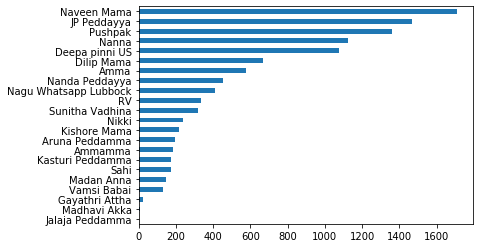

In [88]:
author_value_counts = df['Author'].value_counts().sort_values(ascending=True) # Number of messages per author
top_10_author_value_counts = author_value_counts # Number of messages per author for the top 10 most active authors
top_10_author_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis

In [13]:
null_authors_df = df[df['Author'].isnull()]
null_authors_df

,Date,Time,Author,Text
0,3/14/15,4:09:33 AM,None,Deepa pinni US created this group
1,3/14/15,4:09:33 AM,None,You were added
110,12/5/17,4:07:55 PM,None,âª+91Â 97015Â 84940â¬: ðð»ðð»ðð...
121,12/13/17,2:04:45 PM,None,Deepa pinni US added Nanna
126,12/14/17,12:17:31 AM,None,âª+91Â 97015Â 84940â¬: audio omitted
...,...,...,...,...
11151,4/23/20,5:45:37 AM,None,âª+91Â 99628Â 46244â¬: Very nice picture Kau...
11170,4/25/20,2:05:00 AM,None,âª+91Â 99628Â 46244â¬: image omitted
11176,4/25/20,2:35:44 AM,None,âª+91Â 99628Â 46244â¬: video omitted
11210,4/25/20,11:54:19 PM,None,âª+91Â 99628Â 46244â¬: video omitted


In [14]:
len(df['Date'].unique())

808

       Date        Time       Author           Text
3  11/29/17  1:28:05 AM  Naveen Mama  image omitted
4  11/29/17  1:28:06 AM  Naveen Mama  image omitted
5  11/29/17  1:28:06 AM  Naveen Mama  image omitted
6  11/29/17  1:28:08 AM  Naveen Mama  image omitted
7  11/29/17  1:28:10 AM  Naveen Mama  image omitted
         Date         Time           Author           Text
2    11/28/17  11:39:01 AM   Deepa pinni US  video omitted
109   12/5/17   8:38:51 AM  Sunitha Vadhina  video omitted
115  12/13/17   7:41:37 AM  Sunitha Vadhina  video omitted
116  12/13/17   7:41:38 AM  Sunitha Vadhina  video omitted
120  12/13/17   7:48:42 AM      Naveen Mama  video omitted
Naveen Mama              965
JP Peddayya              774
Deepa pinni US           502
Nanna                    487
Pushpak                  452
Amma                     374
Nanda Peddayya           196
Aruna Peddamma           158
Dilip Mama               136
Nagu Whatsapp Lubbock    126
Name: Author, dtype: int64


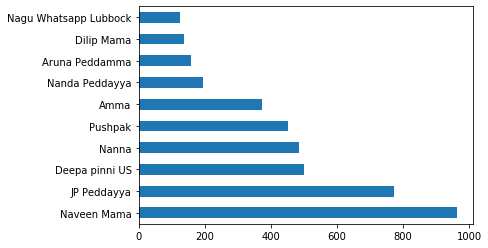

In [47]:
pic_messages_df = df[df['Text'] == 'image omitted']
video_messages_df = df[df['Text'] == 'video omitted']
# media_messages_df_videos = df[df['Text'] == 'video omitted']
# media_messages_df = media_messages_df_images.add(media_messages_df_videos)
print(pic_messages_df.head())
print(video_messages_df.head())

author_pic_messages_value_counts = pic_messages_df['Author'].value_counts()
top_10_author_pic_messages_value_counts = author_pic_messages_value_counts.head(10)
# top_10_author_pic_messages_value_counts.plot.barh()
print(top_10_author_pic_messages_value_counts.head(10))
top_10_author_pic_messages_value_counts.plot.barh()

JP Peddayya         430
Nanna               252
Naveen Mama         129
Deepa pinni US       88
Nanda Peddayya       80
Amma                 70
Kasturi Peddamma     65
Pushpak              45
Kishore Mama         38
Vamsi Babai          30
Name: Author, dtype: int64


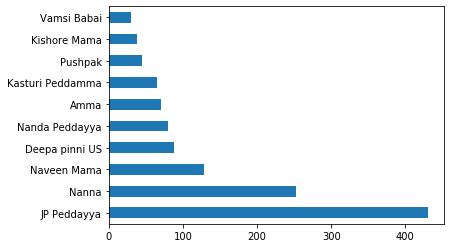

In [49]:
author_video_messages_value_counts = video_messages_df['Author'].value_counts()
top_10_author_video_messages_value_counts = author_video_messages_value_counts.head(10)
# top_10_author_video_messages_value_counts.plot.barh()
print(top_10_author_video_messages_value_counts.head(10))
top_10_author_video_messages_value_counts.plot.barh()

In [48]:
messages_df = df.drop(null_authors_df.index) # Drops all rows of the data frame containing messages from null authors
messages_df = messages_df.drop(media_messages_df.index) # Drops all rows of the data frame containing media messages
messages_df.head()

,Date,Time,Author,Text
2,11/28/17,11:39:01 AM,Deepa pinni US,video omitted
22,11/29/17,2:53:31 AM,Deepa pinni US,Nighty photo super
34,11/29/17,4:22:15 AM,Madan Anna,ð
35,11/29/17,7:30:58 AM,Sunitha Vadhina,Nice pics. Congrats Sravani
62,11/29/17,10:05:05 AM,Pushpak,Abbbabbba


In [51]:
messages_df['Letter_Count'] = messages_df['Text'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Text'].apply(lambda s : len(s.split(' ')))

In [52]:
messages_df.head()

,Date,Time,Author,Text,Letter_Count,Word_Count
2,11/28/17,11:39:01 AM,Deepa pinni US,video omitted,13,2
22,11/29/17,2:53:31 AM,Deepa pinni US,Nighty photo super,18,3
34,11/29/17,4:22:15 AM,Madan Anna,ð,4,1
35,11/29/17,7:30:58 AM,Sunitha Vadhina,Nice pics. Congrats Sravani,27,4
62,11/29/17,10:05:05 AM,Pushpak,Abbbabbba,9,1


In [66]:
discrete_columns = ['Date', 'Time', 'Author', 'Text']
messages_df[discrete_columns].describe()

,Date,Time,Author,Text
count,6371,6371,6371,6371
unique,760,6018,22,4387
top,4/8/20,7:52:00 AM,Pushpak,video omitted
freq,201,4,908,1330


In [67]:
continuous_columns = ['Letter_Count', 'Word_Count']
messages_df[continuous_columns].describe()

,Letter_Count,Word_Count
count,6371.000000,6371.000000
mean,120.972689,12.561921
std,772.150251,59.615171
min,1.000000,1.000000
25%,13.000000,2.000000
50%,19.000000,3.000000
75%,37.000000,6.000000
max,26968.000000,1634.000000


In [68]:
messages_df.describe()

,Letter_Count,Word_Count
count,6371.000000,6371.000000
mean,120.972689,12.561921
std,772.150251,59.615171
min,1.000000,1.000000
25%,13.000000,2.000000
50%,19.000000,3.000000
75%,37.000000,6.000000
max,26968.000000,1634.000000


In [69]:
messages_df['Letter_Count'].sum(), messages_df['Word_Count'].sum()

(770717, 80032)

Text(0, 0.5, 'Authors')

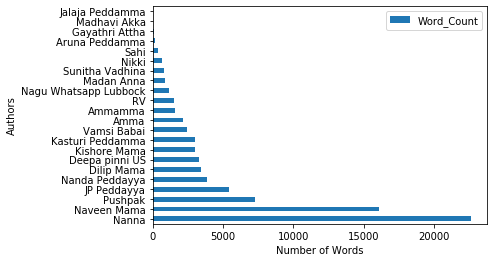

In [71]:
# How many words have been sent in total by each author, since the beginning of time?
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author
top_10_sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

Text(0, 0.5, 'Frequency')

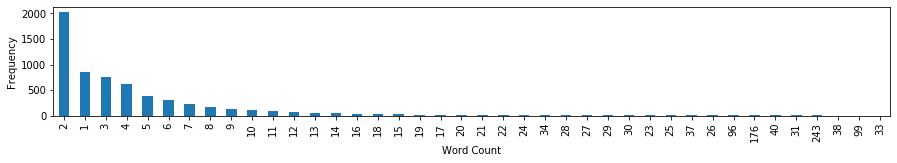

In [72]:
# What is the most common number of words in a message?
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Authors')

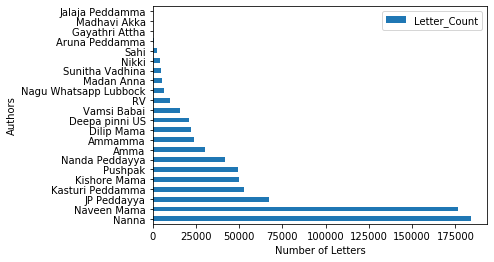

In [74]:
total_letter_count_grouped_by_author = messages_df[['Author', 'Letter_Count']].groupby('Author').sum()
sorted_total_letter_count_grouped_by_author = total_letter_count_grouped_by_author.sort_values('Letter_Count', ascending=False)
top_10_sorted_total_letter_count_grouped_by_author = sorted_total_letter_count_grouped_by_author
top_10_sorted_total_letter_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Letters')
plt.ylabel('Authors')

Text(0, 0.5, 'Frequency')

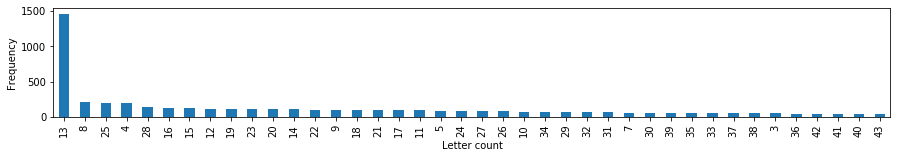

In [75]:
plt.figure(figsize=(15, 2))
letter_count_value_counts = messages_df['Letter_Count'].value_counts()
top_40_letter_count_value_counts = letter_count_value_counts.head(40)
top_40_letter_count_value_counts.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Date')

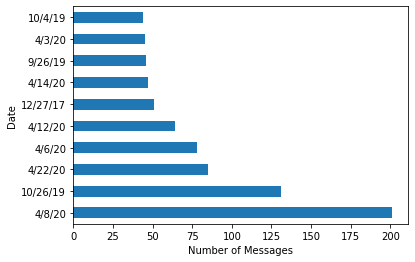

In [76]:
# On which day where the most number of messages sent
messages_df['Date'].value_counts().head(10).plot.barh() # Top 10 Dates on which the most number of messages were sent
plt.xlabel('Number of Messages')
plt.ylabel('Date')

Text(0, 0.5, 'Time')

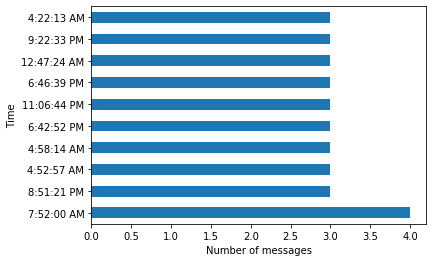

In [77]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

Text(0, 0.5, 'Hour of Day')

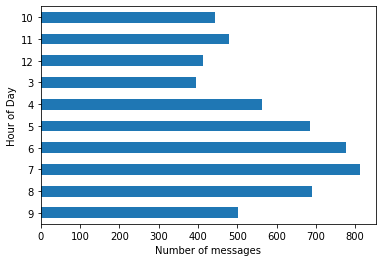

In [78]:
messages_df['Hour'] = messages_df['Time'].apply(lambda x : x.split(':')[0]) # The first token of a value in the Time Column contains the hour (Eg., "20" in "20:15")
messages_df['Hour'].value_counts().head(10).sort_index(ascending=False).plot.barh() # Top 10 Hours of the day during which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

In [89]:
df.head()

,Date,Time,Author,Text
0,3/14/15,4:09:33 AM,None,Deepa pinni US created this group
1,3/14/15,4:09:33 AM,None,You were added
2,11/28/17,11:39:01 AM,Deepa pinni US,video omitted
3,11/29/17,1:28:05 AM,Naveen Mama,image omitted
4,11/29/17,1:28:06 AM,Naveen Mama,image omitted


In [90]:
df_text = df[['Author', 'Text']]

In [91]:
df_text.head()

,Author,Text
0,None,Deepa pinni US created this group
1,None,You were added
2,Deepa pinni US,video omitted
3,Naveen Mama,image omitted
4,Naveen Mama,image omitted


In [92]:
df_by_author = df_text.groupby('Author')

In [105]:
stats = df_by_author.describe()

Text                           
                      count unique            top freq
Author                                                
Amma                    579    119  image omitted  374
Ammamma                 183    142  image omitted   27
Aruna Peddamma          196     27  image omitted  158
Deepa pinni US         1074    436  image omitted  502
Dilip Mama              669    474  image omitted  136
Gayathri Attha           23     20  image omitted    4
JP Peddayya            1465    244  image omitted  774
Jalaja Peddamma           2      2     Superdance    1
Kasturi Peddamma        174     52  video omitted   65
Kishore Mama            218    109  image omitted   62
Madan Anna              149    105  video omitted   17
Madhavi Akka             10      4  image omitted    7
Nagu Whatsapp Lubbock   410    217  image omitted  126
Nanda Peddayya          453    168  image omitted  196
Nanna                  1126    383  image omitted  487
Naveen Mama            1711    552  image omitted  965
Nikki                   240    174  image omitted   29
Pushpak                1360    829  image omitted  452
RV                      334    253  image omitted   61
Sahi                    172     83  image omitted   69
Sunitha Vadhina         321    177  image omitted   78
Vamsi Babai             132     45  image omitted   57

In [111]:
df_text

,Author,Text
0,None,Deepa pinni US created this group
1,None,You were added
2,Deepa pinni US,video omitted
3,Naveen Mama,image omitted
4,Naveen Mama,image omitted
...,...,...
11268,Nanna,Abbo ! All are mouthwatering .I like jalebi v...
11269,Deepa pinni US,Super cuisine skills both Madan and Madhavi......
11270,Naveen Mama,What about aruna Aunty
11271,Deepa pinni US,Aruna Aunty all vegetable cooking


In [117]:
df_text.head()

,Author,Text
0,None,Deepa pinni US created this group
1,None,You were added
2,Deepa pinni US,video omitted
3,Naveen Mama,image omitted
4,Naveen Mama,image omitted


In [118]:
type(df_text)

pandas.core.frame.DataFrame

In [121]:
abc = df_text['Text'].groupby(df['Author'])
# total_salary = df['Salary'].groupby(df['Team'])

In [122]:
abc.head()

0                       Deepa pinni US created this group
1                                          You were added
2                                           video omitted
3                                           image omitted
4                                           image omitted
                              ...                        
9427                            This message was deleted.
9428                                          GIF omitted
9659                            This message was deleted.
9661                                          GIF omitted
9663    Many more happy returns of the day pushpak.god...
Name: Text, Length: 112, dtype: object

In [126]:
abc = df_text.groupby(['Author'])

In [129]:
for auth, txt in abc:
    print(auth)
    print(txt)

Amma
      Author           Text
5852    Amma  image omitted
5884    Amma  image omitted
5885    Amma  image omitted
5886    Amma  image omitted
5887    Amma  image omitted
...      ...            ...
11252   Amma  image omitted
11253   Amma  image omitted
11254   Amma  image omitted
11255   Amma  video omitted
11256   Amma  video omitted

[579 rows x 2 columns]
Ammamma
        Author                                               Text
3805   Ammamma                                      image omitted
3806   Ammamma                                      image omitted
3807   Ammamma                                      image omitted
3808   Ammamma                                      image omitted
4811   Ammamma                    Happy birthday to you    vi van
...        ...                                                ...
10979  Ammamma  à°¸à±à°·à±à°à°¿à°à°°à±à°¤à°²à±à°¨ à°¦à°¿...
10980  Ammamma  à°à°°à±à°¨à°¾ à°à°°à±à°¨à°¾  à°à° à°à±...
10985  Ammamma  à°­à°¾à°°à±à°¯à°

In [144]:
mad = abc.get_group('Madan Anna')
raw_mad_tokens = [mad['Text']]

dil = abc.get_group('Dilip Mama')
raw_dil_tokens = [dil['Text']]

sun = abc.get_group('Sunitha Vadhina')
raw_sun_tokens = [sun['Text']]

gay = abc.get_group('Gayathri Attha')
raw_gay_tokens = [gay['Text']]

nav = abc.get_group('Naveen Mama')
raw_nav_tokens = [nav['Text']]

nik = abc.get_group('Nikki')
raw_nik_tokens = [nik['Text']]

nap = abc.get_group('Nanda Peddayya')
raw_nap_tokens = [nap['Text']]

amm = abc.get_group('Amma')
raw_amm_tokens = [amm['Text']]

mmm = abc.get_group('Ammamma')
raw_mmm_tokens = [mmm['Text']]

nan = abc.get_group('Nanna')
raw_nan_tokens = [nan['Text']]

pus = abc.get_group('Pushpak')
raw_pus_tokens = [pus['Text']]

sah = abc.get_group('Sahi')
raw_sah_tokens = [sah['Text']]

nag = abc.get_group('Nagu Whatsapp Lubbock')
raw_nag_tokens = [nag['Text']]

kas = abc.get_group('Kasturi Peddamma')
raw_kas_tokens = [kas['Text']]

jpp = abc.get_group('JP Peddayya')
raw_jpp_tokens = [jpp['Text']]

jal = abc.get_group('Jalaja Peddamma')
raw_jal_tokens = [jal['Text']]

mdh = abc.get_group('Madhavi Akka')
raw_mdh_tokens = [mdh['Text']]

aru = abc.get_group('Aruna Peddamma')
raw_aru_tokens = [aru['Text']]

rah = abc.get_group('RV')
raw_rah_tokens = [rah['Text']]

vam = abc.get_group('Vamsi Babai')
raw_vam_tokens = [vam['Text']]

dee = abc.get_group('Deepa pinni US')
raw_dee_tokens = [dee['Text']]

kis = abc.get_group('Kishore Mama')
raw_kis_tokens = [kis['Text']]




In [147]:
raw_tokens = {"Madan":raw_mad_tokens,
              "Sunitha":raw_sun_tokens,
              "Nanda":raw_nap_tokens,
              "Aruna":raw_aru_tokens,
              "Madhavi":raw_mdh_tokens,
              "Kishore":raw_kis_tokens,
              "Naveen":raw_nav_tokens,
              "Nikki":raw_nik_tokens,
              "Anu":raw_amm_tokens,
              "Ramesh":raw_nan_tokens,
              "Pushpak":raw_pus_tokens,
              "Deepa":raw_dee_tokens,
              "Vamsi":raw_vam_tokens,
              "Dilip":raw_dil_tokens,
              "Gayathri":raw_gay_tokens,
              "Nagu":raw_nag_tokens,
              "Sahi":raw_sah_tokens,
              "Kasturi":raw_kas_tokens,
              "JP":raw_jpp_tokens,
              "Jalaja":raw_jal_tokens,
              "Saraswati":raw_mmm_tokens,
              "Rahul":raw_rah_tokens
             }

In [151]:
raw_tokens.get('Rahul')

[69       is bringing home and unpacking considered home...
 70                 looks delicious though ðð»ðð»
 72                                                    haha
 73                                    atleast i tried ð
 74                                        oorke pinni ð
                                ...                        
 11087                    true translation endhuk ra manaku
 11090                           nara naraallo telugu undhi
 11103                                             ðð
 11162    adhe paristiti peddhayya! sanitizer lu vadi va...
 11163                                     *ollu illu rendu
 Name: Text, Length: 334, dtype: object]